In [362]:
import warnings
warnings.filterwarnings(action='ignore')

In [363]:
#%pip install pgmpy
#%pip install matplotlib
#%pip install scipy
#%pip install seaborn
#%pip install sklearn
#%pip install networkx

from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, normalize
from sklearn.metrics import accuracy_score, classification_report

from copy import copy
import networkx as nx

from pgmpy.estimators import HillClimbSearch, BDeuScore, K2Score, BicScore, TreeSearch
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

In [364]:
#this function is the numerator of the target distribution
def f(x):
    if x >= 0:
        return  np.exp(-(x/5)**4)
    else: 
        return  np.exp(-(1/10*x)**2+x)

#normal PDF
def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

In [365]:
data = pd.read_csv('/opt/notebooks/owid-covid-data.csv')
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231404,ZWE,Africa,Zimbabwe,2022-10-26,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231405,ZWE,Africa,Zimbabwe,2022-10-27,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231406,ZWE,Africa,Zimbabwe,2022-10-28,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231407,ZWE,Africa,Zimbabwe,2022-10-29,257893.0,0.0,0.0,5606.0,0.0,0.0,...,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN


In [366]:
columns = ['total_deaths_per_million',
            'positive_rate',
            'reproduction_rate',
            'new_people_vaccinated_smoothed_per_hundred',
            'gdp_per_capita',
            'population_density',
            'life_expectancy',
            'extreme_poverty',
            'hospital_beds_per_thousand',
            'total_cases_per_million'
           ]
df = data[columns].copy().dropna()
df.index = np.arange(0, len(df))
df.head()

,total_deaths_per_million,positive_rate,reproduction_rate,new_people_vaccinated_smoothed_per_hundred,gdp_per_capita,population_density,life_expectancy,extreme_poverty,hospital_beds_per_thousand,total_cases_per_million
0,438.726,0.1812,1.06,0.002,11803.431,104.871,78.57,1.1,2.89,22506.630
1,440.486,0.1788,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,22737.428
2,441.893,0.1825,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,22986.168
3,443.652,0.1807,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,23218.373
4,445.059,0.1825,1.07,0.002,11803.431,104.871,78.57,1.1,2.89,23443.893


In [367]:
targets = ['reproduction_rate', 'total_deaths_per_million', 'total_cases_per_million']
predictors = [
    'positive_rate',
    'new_people_vaccinated_smoothed_per_hundred',
    'gdp_per_capita',
    'population_density',
    'life_expectancy',
    'extreme_poverty',
    'hospital_beds_per_thousand'
]

## 2

In [368]:
def draw_sampling_plots(sampling_hist_fn):
    data = {}

    for target_var in targets:

        sampled, n_bins = inv_trans_sampling_hist(df[target_var], 
                                                  num_samples=df.shape[0])

        data[target_var] = sampled

        freqs, bin_edges = np.histogram(df[target_var], bins=n_bins)
        freqs += 1
        freqs_sampled = np.bincount(np.concatenate([np.digitize(sampled, bin_edges) - 1, 
                                                    np.arange(n_bins)]))

        percs = np.linspace(0, 100, n_bins)
        qn_gt = np.percentile(df[target_var], percs)
        qn_sampled = np.percentile(sampled, percs)

        fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharex=False, sharey=False)

        sns.kdeplot(df[target_var], ax=ax[0], shade=True, color='g')
        ax[0].set_xlabel(None)
        ax[0].set_title("Real")

        sns.kdeplot(sampled, ax=ax[1], shade=True, color='orange')
        ax[1].set_title(f"Simulated")

        ax[2].plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
        ax[2].plot(qn_gt, qn_gt, color="k", ls="--")
        ax[2].set_xlabel("Real")
        ax[2].set_ylabel("Simulated")
        ax[2].set_title("QQ biplot")

        fig.suptitle(f"{target_var}")
        plt.plot();
    
    return data

In [369]:
def inv_trans_sampling_hist(values, num_samples=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    uniform_values = np.random.rand(num_samples)
    
    return inversed_cdf(uniform_values), n_bins

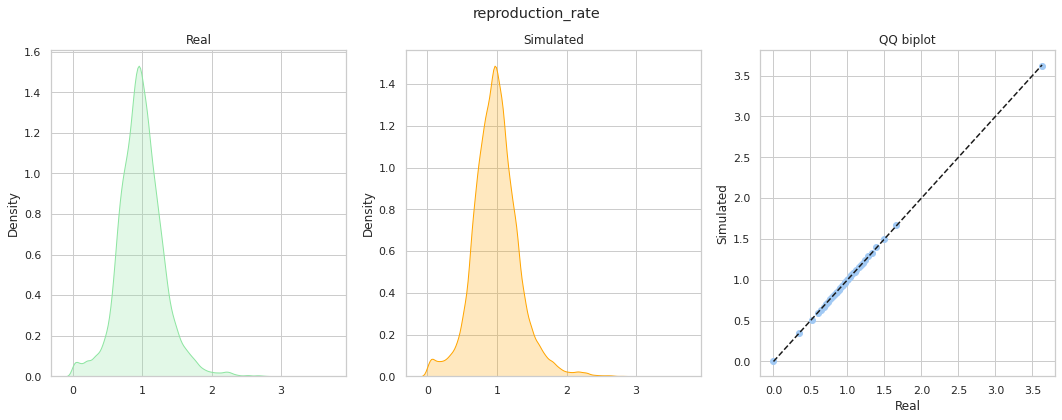

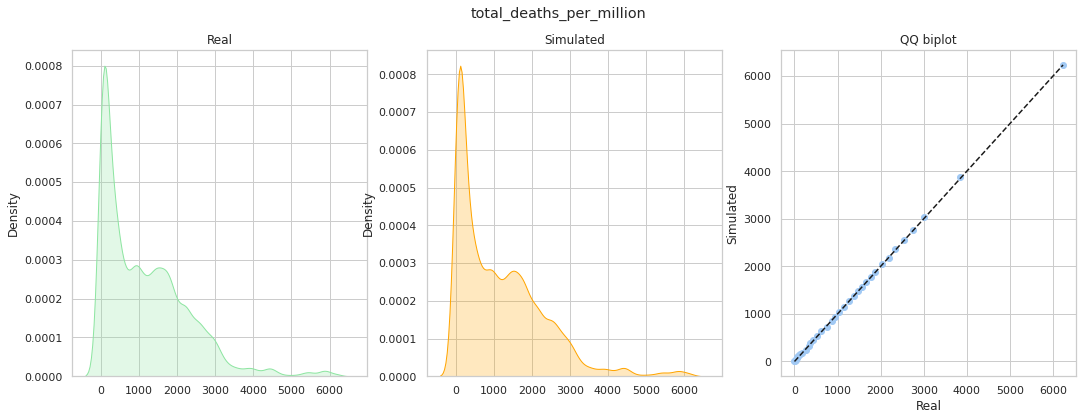

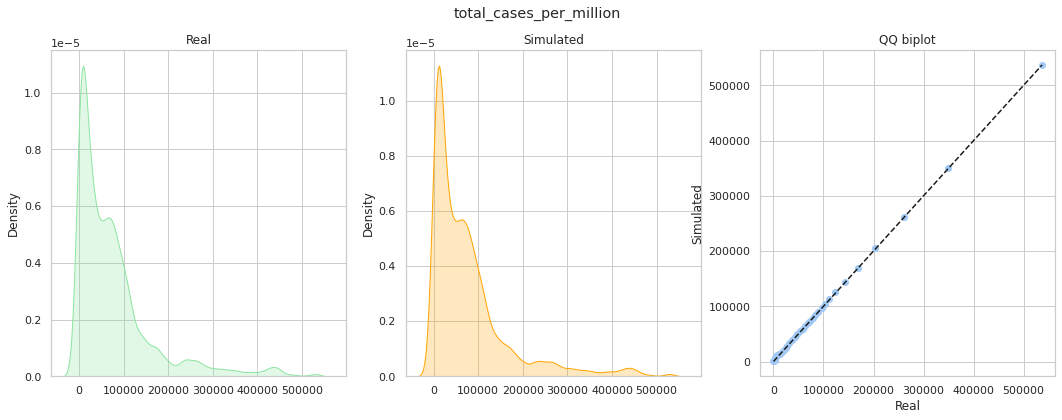

In [370]:
it_sampled_df = pd.DataFrame(draw_sampling_plots(inv_trans_sampling_hist))

In [371]:
def geom_sampling_hist(values, num_samples=1000, batch_size=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    left, right = np.min(bin_edges), np.max(bin_edges)
    bottom, top = np.min(hist), np.max(hist)
    
    accept_samples = np.asarray([])
    
    while accept_samples.shape[0] < num_samples:
        
        x_sampl = np.random.uniform(left, right, size=(batch_size,))
        y_sampl = np.random.uniform(bottom, top, size=(batch_size,))
        
        x_indices = np.digitize(x_sampl, bin_edges) - 1
        y_mask = (y_sampl <= hist[x_indices])
        
        accept_samples = np.concatenate([accept_samples, x_sampl[y_mask]])
        
    return accept_samples[:num_samples], n_bins

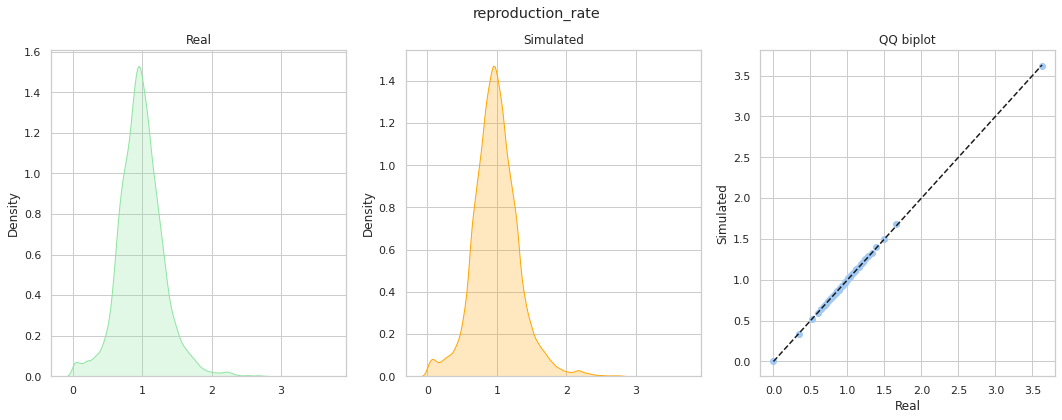

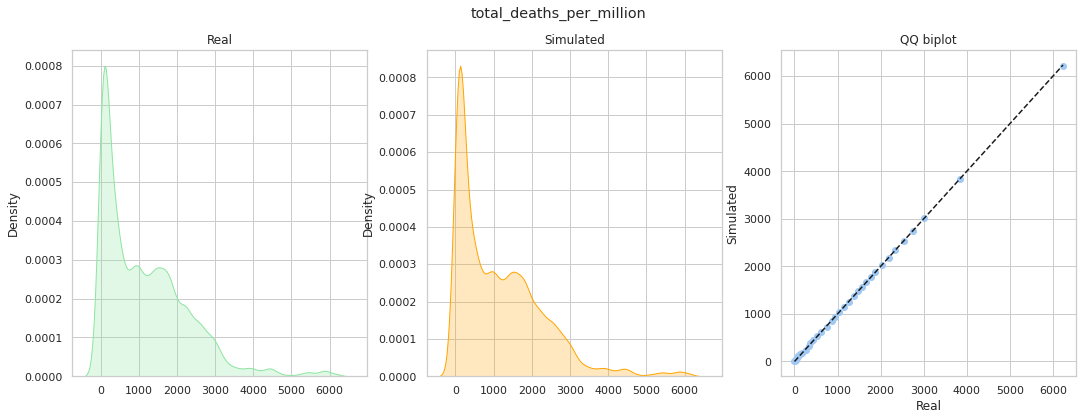

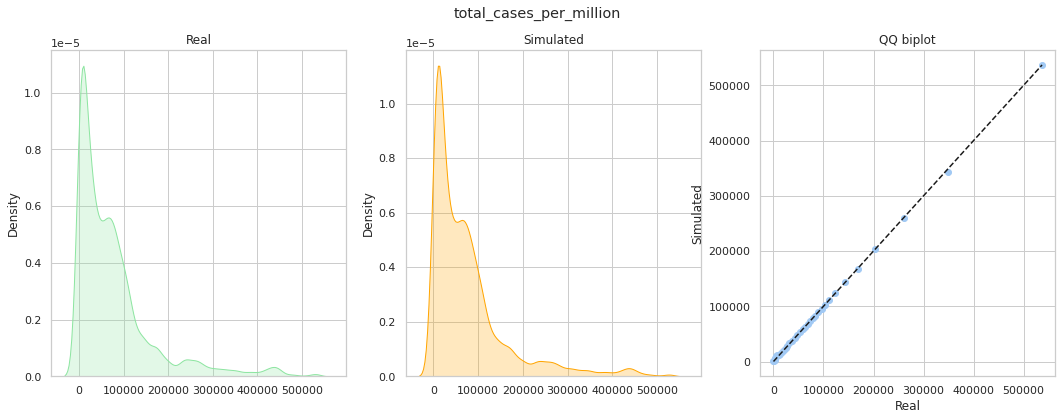

In [372]:
gs_sampled_df = pd.DataFrame(draw_sampling_plots(geom_sampling_hist))

## 3

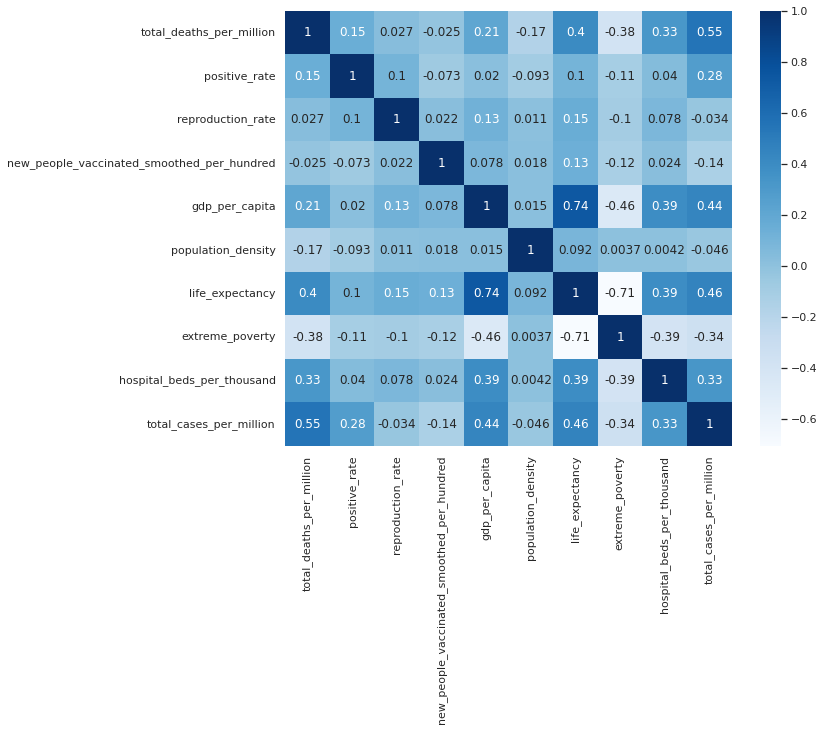

In [373]:
figure, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_theme(style='whitegrid', palette='pastel')

sns.heatmap(df[columns].corr(), cmap='Blues', annot=True)

plt.show()

## 4

In [374]:
edges_list = [
    ('gdp_per_capita', 'total_deaths_per_million'),
    ('life_expectancy', 'total_deaths_per_million'),
    ('life_expectancy', 'gdp_per_capita'),
    ('extreme_poverty', 'total_deaths_per_million'),
    ('extreme_poverty', 'gdp_per_capita'),
    ('extreme_poverty', 'life_expectancy'),
    ('hospital_beds_per_thousand', 'total_deaths_per_million'),
    ('hospital_beds_per_thousand', 'gdp_per_capita'),
    ('hospital_beds_per_thousand', 'life_expectancy'),
    ('hospital_beds_per_thousand', 'extreme_poverty'),
    ('total_cases_per_million', 'total_deaths_per_million'),
    ('total_cases_per_million', 'positive_rate'),
    ('total_cases_per_million', 'gdp_per_capita'),
    ('total_cases_per_million', 'life_expectancy'),
    ('total_cases_per_million', 'extreme_poverty'),
    ('total_cases_per_million', 'hospital_beds_per_thousand')
]

our_model = BayesianModel(edges_list)

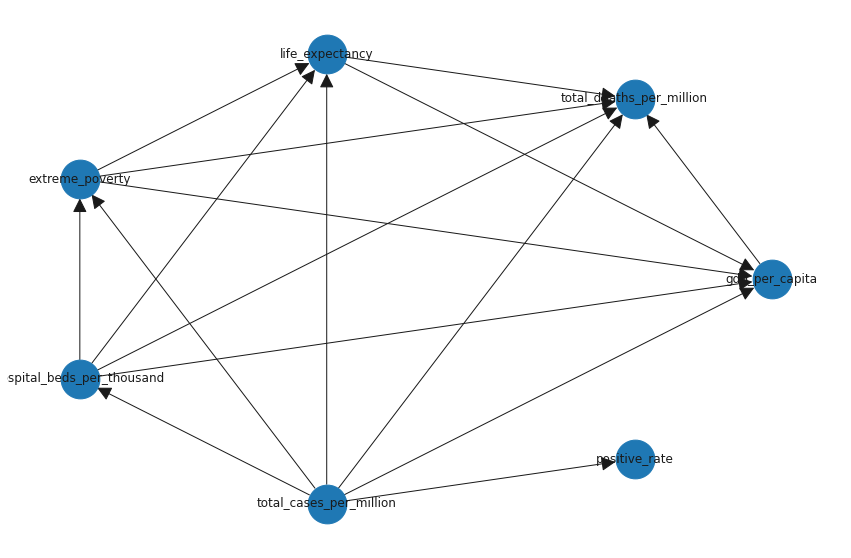

In [375]:
figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(our_model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_size=1500, arrowsize=30)

plt.show()

In [376]:
subdata = df[[node for node in our_model.nodes()]]

In [377]:
transformed_data = subdata.copy()
bins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans')
data_discrete = bins.fit_transform(subdata.values)

In [378]:
data_discrete = pd.DataFrame(data_discrete, columns=subdata.columns,index=subdata.index)
data_discrete

,gdp_per_capita,total_deaths_per_million,life_expectancy,extreme_poverty,hospital_beds_per_thousand,total_cases_per_million,positive_rate
0,1.0,0.0,5.0,0.0,2.0,0.0,2.0
1,1.0,0.0,5.0,0.0,2.0,0.0,2.0
2,1.0,0.0,5.0,0.0,2.0,0.0,2.0
3,1.0,0.0,5.0,0.0,2.0,0.0,2.0
4,1.0,0.0,5.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...
39607,0.0,0.0,0.0,2.0,1.0,0.0,1.0
39608,0.0,0.0,0.0,2.0,1.0,0.0,1.0
39609,0.0,0.0,0.0,2.0,1.0,0.0,1.0
39610,0.0,0.0,0.0,2.0,1.0,0.0,1.0


In [379]:
from pgmpy.estimators import MaximumLikelihoodEstimator

In [380]:
our_model.fit(data_discrete, estimator=MaximumLikelihoodEstimator)

## 5

In [381]:
hc = HillClimbSearch(data_discrete)
model_K2 = hc.estimate(scoring_method=K2Score(data_discrete))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0xffff5caef940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/opt/conda/lib/python3.9/site-packages/tqdm/notebook.py", line 290, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


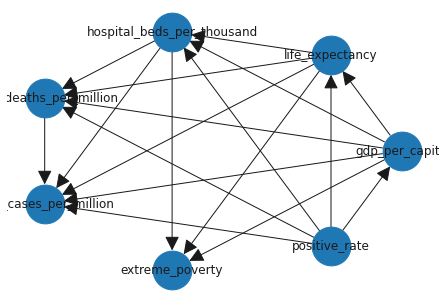

In [382]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(model_K2.edges())
positions = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, positions, with_labels=True, node_size=1500, arrowsize=30)

In [385]:
TS = TreeSearch(data_discrete)
model_TS = TS.estimate(estimator_type='chow-liu')

Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

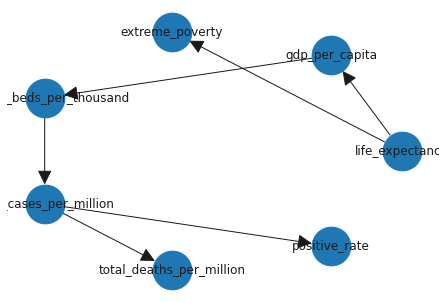

In [386]:
G_TS = nx.DiGraph()
G_TS.add_edges_from(model_TS.edges())
positions = nx.layout.circular_layout(G_TS)
nx.draw(G_TS, positions, with_labels=True, node_size=1500, arrowsize=30)

## 6

In [387]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [388]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()

In [389]:
sample_our = sampling(our_model, data_discrete, 10000)
sample_K2 = sampling(model_K2, data_discrete, 10000)
sample_TS = sampling(model_TS, data_discrete, 10000)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [390]:
discret_samples = [sample_our.copy(), sample_K2.copy(), sample_TS.copy()]
samples = [sample_our, sample_K2, sample_TS]
for sample in samples:
    sample[[
        'gdp_per_capita',
        'total_deaths_per_million',
        'life_expectancy',
        'extreme_poverty',
        'hospital_beds_per_thousand',
        'total_cases_per_million',
        'positive_rate'
    ]] = bins.inverse_transform(sample)

In [391]:
labels = ['Manually-created network', 'Hill Climb (K2)', 'Tree Search']

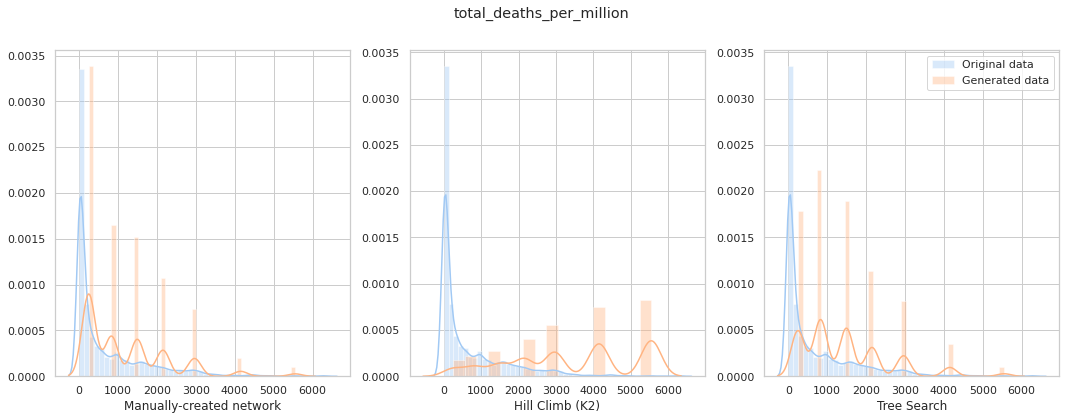

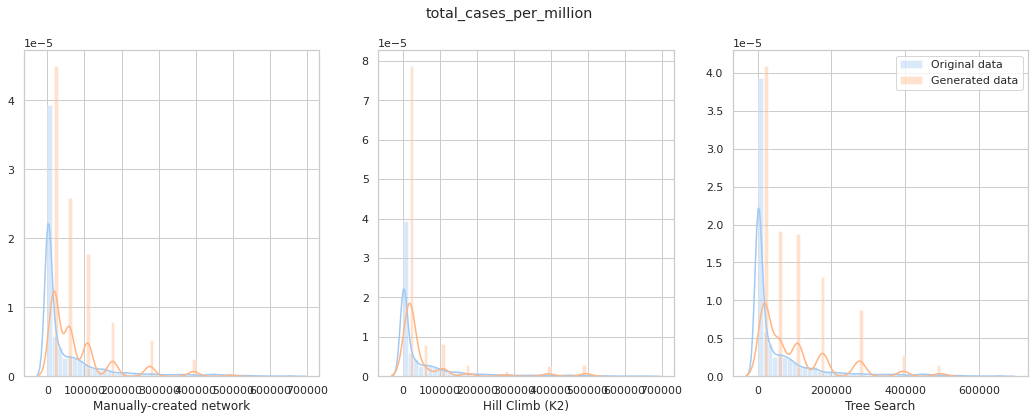

In [392]:
for target in targets[1:]:
    fig, ax = plt.subplots(ncols=3, figsize=(18, 6), sharex=False, sharey=False)
    
    for i, ax_i in enumerate(ax):
        sns.distplot(data[target], ax=ax_i, label='Original data')
        sns.distplot(samples[i][target], ax=ax_i, label='Generated data')
        ax_i.set_ylabel('')
        ax_i.set_xlabel(labels[i])
    
    fig.suptitle(target)
    
    plt.plot();
    plt.legend();

## Quantity quality analysis

In [408]:
from sklearn.metrics import mean_squared_error

### total_deaths_per_million

In [399]:
for i, sample in enumerate(discret_samples):
    print(classification_report(data_discrete['total_deaths_per_million'][:10000], sample['total_deaths_per_million']))

Manually-created network
              precision    recall  f1-score   support

         0.0       0.31      0.40      0.35      3046
         1.0       0.16      0.17      0.16      1772
         2.0       0.20      0.18      0.19      1913
         3.0       0.16      0.13      0.14      1535
         4.0       0.12      0.08      0.09      1271
         5.0       0.03      0.02      0.03       316
         6.0       0.01      0.01      0.01       147

    accuracy                           0.22     10000
   macro avg       0.14      0.14      0.14     10000
weighted avg       0.20      0.22      0.21     10000

Hill Climb (K2)
              precision    recall  f1-score   support

         0.0       0.31      0.40      0.35      3046
         1.0       0.18      0.20      0.19      1772
         2.0       0.19      0.18      0.19      1913
         3.0       0.15      0.12      0.13      1535
         4.0       0.14      0.09      0.11      1271
         5.0       0.03      0.02    

In [421]:
print('--- MRSE ---')
for i, sample in enumerate(samples):
    print(labels[i] + ': ' + str(mean_squared_error(data_discrete['total_deaths_per_million'][:10000], sample['total_deaths_per_million'], squared=False)))

--- MRSE ---
Manually-created network: 1621.3226381059703
Hill Climb (K2): 3785.0184021043524
Tree Search: 1814.3099678857006


### total_cases_per_million

In [397]:
for sample in discret_samples:
    print(classification_report(data_discrete['total_cases_per_million'][:10000], sample['total_cases_per_million']))

              precision    recall  f1-score   support

         0.0       0.32      0.44      0.37      3191
         1.0       0.31      0.25      0.28      3132
         2.0       0.23      0.18      0.20      2114
         3.0       0.08      0.06      0.07       905
         4.0       0.04      0.05      0.04       341
         5.0       0.01      0.02      0.02       126
         6.0       0.04      0.01      0.02       191

    accuracy                           0.26     10000
   macro avg       0.15      0.14      0.14     10000
weighted avg       0.26      0.26      0.26     10000

              precision    recall  f1-score   support

         0.0       0.32      0.43      0.37      3191
         1.0       0.31      0.24      0.27      3132
         2.0       0.21      0.16      0.18      2114
         3.0       0.10      0.09      0.10       905
         4.0       0.03      0.05      0.04       341
         5.0       0.01      0.02      0.02       126
         6.0       0.00 

In [422]:
print('--- MRSE ---')

for i, sample in enumerate(samples):
    print(labels[i] + ': ' + str(mean_squared_error(data_discrete['total_cases_per_million'][:10000], sample['total_cases_per_million'], squared=False)))

--- MRSE ---
Manually-created network: 118806.56445676148
Hill Climb (K2): 117967.23478682806
Tree Search: 144053.9001087486
